<a href="https://colab.research.google.com/github/sohumgautam17/Cell_Seg_Count-CMU/blob/main/CMU_CSegNET_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sohumgautam17/Cell_Seg_Count-CMU.git

Cloning into 'Cell_Seg_Count-CMU'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 146 (delta 53), reused 3 (delta 1), pack-reused 0
Receiving objects: 100% (146/146), 109.82 MiB | 8.79 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Updating files: 100% (67/67), done.


In [2]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16429 sha256=50162a7ce5a20cb3fd742d93f30b40e5600eb70922ef61353bdc8ec61c1a4e15
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=15cf8039232fe7e3611f7fa1a42c1fca3b4cc19823becb1fa1104ec5eb864897
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [34]:
import torch
import sklearn
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import requests
from pathlib import Path
import xml.etree.ElementTree as ET
from PIL import Image
from torch import nn
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from tqdm.auto import tqdm
from torchvision.transforms.functional import hflip, vflip

In [4]:
!pwd  # Print current directory
!ls   # List contents of current directory

# Check current directory and change it if needed
if not "$(pwd)" == "/content/Cell_Seg_Count-CMU":
    %cd Cell_Seg_Count-CMU

/content
Cell_Seg_Count-CMU  sample_data
/content/Cell_Seg_Count-CMU


#Downloading/Parse the Data and Inspect


In [5]:
from process_data import he_to_binary_mask

files_path = "./Tissue Images"
filename = []

for each_file in os.listdir(files_path):
  each_file = each_file[:-4]
  filename.append(each_file)

print(filename[:5])


30
30


Processing: 100%|██████████| 30/30 [01:21<00:00,  2.72s/it]


['TCGA-E2-A1B5-01Z-00-DX1', 'TCGA-18-5592-01Z-00-DX1', 'TCGA-G2-A2EK-01A-02-TSB', 'TCGA-A7-A13F-01Z-00-DX1', 'TCGA-G9-6348-01Z-00-DX1']


In [6]:
## testing with 2 files
filename = filename[:10]
orig_binmask_colormask = []
for i in filename:
  orig_binmask_colormask.append(he_to_binary_mask(i))
len(orig_binmask_colormask)

10

In [7]:
for data in orig_binmask_colormask:
    first_key, first_value = next(iter(data.items()))
    image_array = np.array(first_value)
    print(image_array.dtype)
    img_flip_ud = cv2.flip(image_array, 0)
    img_rotated = np.rot90(img_flip_ud, k=3)
    data[first_key] = img_rotated

uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8
uint8


In [8]:
###EXAMPLE VISUALIZATIONS...
image = 2
orig = orig_binmask_colormask[image-1]['original_image']
binary_mask = orig_binmask_colormask[image-1]["binary_mask"]
color_mask = orig_binmask_colormask[image-1]['color_mask']

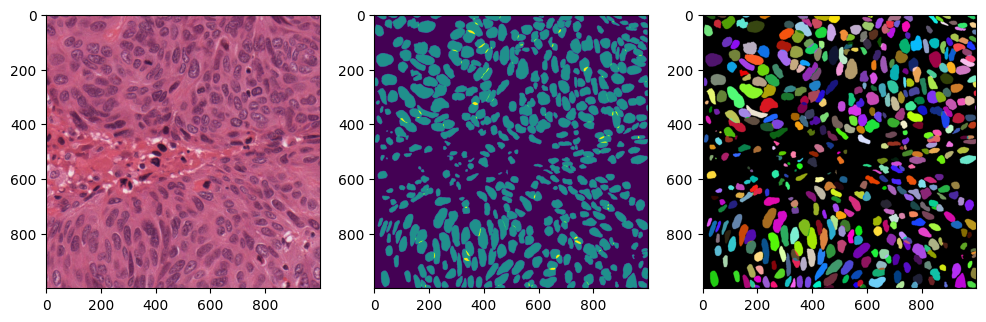

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

# Assuming 'orig', 'binary_mask', and 'color_mask' contain your image data

# Normalize each image before visualization
axes[0].imshow(orig / 255.0)  # Assuming orig is in the range [0, 255]
axes[1].imshow(binary_mask / 255.0)  # Assuming binary_mask is in the range [0, 255]
axes[2].imshow(color_mask / 255.0)  # Assuming color_mask is in the range [0, 255]

plt.show()

#Getting Data Ready for Batching

In [10]:
X = [] # this will store all original images
y = [] # this will store all binary masked images, we can change this to color masks later, but for rn
for dictionary in orig_binmask_colormask:
  X.append(dictionary['original_image'])
  y.append(dictionary['binary_mask'])


In [11]:
import numpy
X_tensor = torch.Tensor(numpy.array(X))
X_tensor = torch.permute(X_tensor, (0, 3, 1, 2))
y_tensor = torch.Tensor(numpy.array(y))

In [12]:
X_tensor.shape, y_tensor.shape

(torch.Size([10, 3, 1000, 1000]), torch.Size([10, 1000, 1000]))

#Setup Configs + Batching



In [13]:
EPOCHS = 5

BATCH_SIZE = 1
LR = 0.05
test_ratio = 0.3

ENCODER = 'timm-efficientnet-b7'
WEIGHTS = 'imagenet'

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=test_ratio, random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(7, 3, 7, 3)

In [16]:
print(X_train.shape)
print(y_train.shape)

torch.Size([7, 3, 1000, 1000])
torch.Size([7, 1000, 1000])


In [17]:
train_set = TensorDataset(X_train,  y_train)
test_set = TensorDataset(X_test, y_test)

In [18]:
train_set

In [19]:
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE)

In [20]:
print(len(train_loader))
print(len(test_loader))


7
3


In [21]:
!ls

 Annotations		       process_data.py	 read_xml.py		  UNET_model.py
 CMU_CSegNET_Pipeline.ipynb    __pycache__	 resize_and_patching.py   visualize.py
 image_annot_data_struct.npy   README.md	'Tissue Images'


#Segmentation Model ... Temporary until the model file is built

In [23]:
import process_data

In [24]:
from UNET_model import UNet

n_channels = 3
n_classes = 2
bilinear = True

model_0 = UNet(n_channels, n_classes, bilinear)
model_0

# class SegmentationModel(nn.Module):
#   def __init__(self, num_classes=1):
#     super().__init__()
#     #self.pad = nn.ZeroPad2d((6, 6, 6, 6))
#     self.architecture = smp.Unet(
#       encoder_name=ENCODER,
#       encoder_weights = WEIGHTS,
#       in_channels = 3,
#       classes=num_classes
#     )

#   def forward(self, x):
#     orig_h, orig_w = x.size()[-2:]
#     # Apply padding to make the dimensions divisible by 32
#     pad_h = ((orig_h // 32) + 1) * 32 - orig_h
#     pad_w = ((orig_w // 32) + 1) * 32 - orig_w
#     # Apply padding
#     x = nn.ZeroPad2d((0, pad_w, 0, pad_h))(x)
#     # Pass the padded input through the UNet architecture
#     output = self.architecture(x)
#     return output

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

#Visualize Visualize Visualize


In [31]:
def visualize_segmentation(images, masks, preds, num_images=2):

    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # Convert to NHWC for visualization
    print(masks.shape)
    masks = masks.cpu().numpy()
    print(preds.shape)
    preds = torch.argmax(preds, dim=1).cpu().numpy()  # Convert predictions to class indices

    fig, axs = plt.subplots(num_images, 3, figsize=(10, 3 * num_images))

    for i in range(num_images):
        img = images[i]
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1] for displaying

        ax = axs[i, 0]
        ax.imshow(img)
        ax.set_title("Original Image")
        ax.axis('off')

        ax = axs[i, 1]
        ax.imshow(img)
        ax.imshow(masks[i], alpha=0.3, cmap='magma')  # Overlay mask
        ax.set_title("Ground Truth Mask")
        ax.axis('off')

        ax = axs[i, 2]
        ax.imshow(img)
        ax.imshow(preds[i], alpha=0.3, cmap='jet')  # Overlay prediction
        ax.set_title("Predicted Mask")
        ax.axis('off')

    plt.tight_layout()
    plt.savefig('./test.png')
    plt.close()

torch.Size([1, 1000, 1000])
torch.Size([1, 2, 1000, 1000])


IndexError: index 1 is out of bounds for axis 0 with size 1

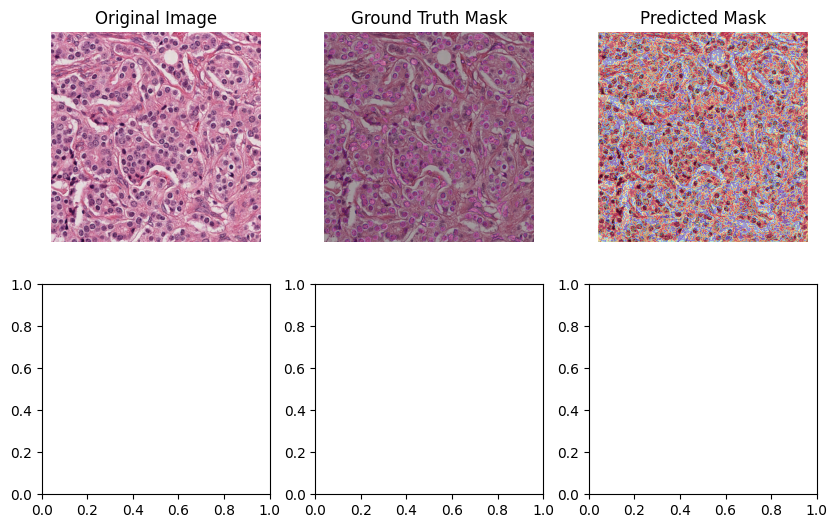

In [32]:
#practice inference on untrained model
for image, annote in test_loader:
  logits = model_0(image)
  visualize_segmentation(image, annote, logits)
# batch_size = 7
# images = torch.randn(batch_size, 3, 512, 512).to(device)  # Random images
# targets = torch.randint(0, 2, (batch_size, 512, 512)).to(device)  # Random ground truth masks
# outputs = model(images)  # Model predictions

# # Visualize the first 3 images, masks, and predictions
# visualize_segmentation(images.detach().cpu(), targets.detach().cpu(), outputs.detach().cpu(), num_images=3)

#Training Loop

In [35]:
loss_fn = DiceLoss(mode='binary')
#loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=LR)

In [62]:
def train(model, optimizer):
  model.train()
  total_train_loss = 0
  for epoch in tqdm(range(EPOCHS)):
    epoch_train_loss = 0
    for batch_idx, (image, annote) in enumerate(train_loader):
      print(f"Epoch #{epoch} Batch #{batch_idx}...")
      #print(annote.shape)
      logits = model(image)
      annote = annote.unsqueeze(1)


      print(logits.shape)
      print(annote.shape)


      loss  = loss_fn(logits, annote)
      print(f"Batch Loss : {loss}")

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_train_loss /= len(train_loader)
      total_train_loss += epoch_train_loss


  total_train_loss /= EPOCHS
  return total_train_loss



In [63]:
def eval(model):
  model.eval()
  total_test_loss = 0
  with torch.inference_mode():
    for image, annote in test_loader:
      test_logits = model(image)
      #reshaped_logits = torch.nn.functional.pad(test_logits, (-12,-12,-12,-12), 'constant', value=1.2)
      loss = loss_fn(test_logits, annote)

      total_test_loss += loss

  return total_test_loss/EPOCHS



In [66]:
train(model_0, optimizer)

  0%|          | 0/5 [00:02<?, ?it/s]

Epoch #0 Batch #0...
torch.Size([1, 2, 1000, 1000])
torch.Size([1, 1, 1000, 1000])


AssertionError: 

In [ ]:
for image, annote in test_loader:
  logits = model_0(image)
  visualize_segmentation(image, annote, logits, num_images=1)

In [ ]:
from pathlib import Path

MODEL_PATH = Path("/content/Cell_Seg_Count-CMU")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "trained_seg_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
#MODEL_SAVE_PATH

print(f'Saving model to {MODEL_SAVE_PATH}')
#torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving model to /content/Cell_Seg_Count-CMU/trained_seg_model_0.pth


In [ ]:
eval(model_0)

tensor(0.3566)

#Inference

In [ ]:
model_0.load_state_dict(torch.load())
idx = 3
image, mask = X_test[idx], y_test[idx]

logits_mask = model(iamge)  ## unsqueeze??
pred_mask = torch.sigmoid(logits_mask)
pred_mask.shape


In [ ]:
## visualize mask
